In [4]:
%load_ext autoreload
%autoreload 2a

import importlib
import io
import os
import sys
import csv
import gzip
import time
import secrets
import multiprocessing
import resource
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
import itertools
import collections
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
import lcwgsus

from scipy.stats import poisson
from scipy.stats import chi2
from scipy.stats import friedmanchisquare
from scipy.stats import studentized_range
pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/

# from matplotlib import colormaps
# list(colormaps)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/gpfs3/well/band/users/rbx225/GAMCC


In [3]:
# If a function was added to the package, I have to reload the specific module rather than the whole package
importlib.reload(lcwgsus)

<module 'lcwgsus' from '/well/band/users/rbx225/software/lcwgsus/lcwgsus/__init__.py'>

In [33]:
db = sqlite3.connect( "results/chip/qc/chip.qc.sqlite" )
snp = pd.read_sql_query( "SELECT * FROM autosomesView", db )
sample = pd.read_sql_query( "SELECT * FROM sample_statsView", db )
ethnic = pd.read_csv('data/metadata/ethnic_group.csv')
ethnic = ethnic.rename(columns = {'Chip_Name': 'sample_id'})
PC = pd.read_sql_query( "SELECT * FROM PCsView", db )
PC = PC[PC['analysis']=='PCs:thin_1bp:exclude-duplicates']
PC = PC.merge(ethnic, on = 'sample_id', how = 'left')

kinship = pd.read_csv( "results/chip/qc/PCs/chip_kinship_thin_1bp.exclude-duplicates.tsv.gz", comment = '#', sep = '\t')

In [40]:
snp_missing = 0.05
snp_hwe = 1e-6
sample_missing = 0.05
heterozygosity_nstd = 3

drop_history = {}
num = snp.shape[0]
drop_history['original'] = num

snp = snp[~snp['chromosome'].isin(['MT', 'NA'])]
drop_history['drop_non-autosome'] = num - snp.shape[0]
num = snp.shape[0]
snp = snp[snp['missing_proportion'] < 0.2]
drop_history['drop_snp_missing_0.2'] = num - snp.shape[0]
num = snp.shape[0]
snp = snp[snp['HW_exact_p_value'] > snp_hwe]
drop_history['drop_snp_hwe_1e-6'] = num - snp.shape[0]
num = snp.shape[0]
snp = snp[snp['missing_proportion'] < snp_missing]
drop_history['drop_snp_missing_0.05'] = num - snp.shape[0]
num = snp.shape[0]

# sample = sample[sample['missing_proportion'] < sample_missing]
# std = sample['heterozygous_proportion'].std()
# mean = sample['heterozygous_proportion'].mean()
# sample = sample[(sample['heterozygous_proportion'] > mean - heterozygosity_nstd*std) & (sample['heterozygous_proportion'] < mean + heterozygosity_nstd*std)]

In [43]:
chromosomes = [i for i in range(1,23)]
oneKGmafs = ["/well/band/users/rbx225/GAMCC/data/oneKG_MAFs/oneKG_MAF_afr_chr" + str(i) + ".txt" for i in chromosomes]
oneKGaf = lcwgsus.multi_read_af(chromosomes, oneKGmafs)
oneKGaf = oneKGaf.rename(columns = {'MAF': 'prop'})
oneKGaf['prop'] = np.where(oneKGaf['prop'] > 0.5, 1 - oneKGaf['prop'], oneKGaf['prop'])

GGVPmafs = ["/well/band/users/rbx225/recyclable_files/AFs/ggvp_AFs/ggvp_AF_chr" + str(i) + ".txt" for i in chromosomes]
GGVPaf = lcwgsus.multi_read_af(chromosomes, GGVPmafs)
GGVPaf = GGVPaf.rename(columns = {'MAF': 'prop'})
GGVPaf['prop'] = np.where(GGVPaf['prop'] > 0.5, 1 - GGVPaf['prop'], GGVPaf['prop'])
af = pd.merge(oneKGaf, GGVPaf, on = ['chr', 'pos', 'ref', 'alt'], how = 'outer')
af['prop'] = af['prop_x'].combine_first(af['prop_y'])
af = af.drop(columns = ['prop_x', 'prop_y'])

In [41]:
chip_af = snp[['chromosome', 'position', 'alleleA', 'alleleB', 'minor_allele_frequency']]
chip_af = chip_af.rename(columns = {'chromosome': 'chr', 'position': 'pos', 'alleleA': 'ref', 'alleleB': 'alt', 'minor_allele_frequency': 'prop'})
chip_af = chip_af[chip_af['chr'].isin([str(i) for i in range(1,23)])]
chip_af['chr'] = chip_af['chr'].astype(int)
chip_af['ref'] = chip_af['ref'].astype(str)
chip_af['alt'] = chip_af['alt'].astype(str)

In [79]:
def hack_indel(row):
    if row['ref'][-1] == row['alt'][-1]:
        if len(row['ref']) == 1:
            row['ref'] = '-'
            row['alt'] = row['alt'][:-1]
        elif len(row['alt']) == 1:
            row['alt'] = '-'
            row['ref'] = row['ref'][:-1]
        else:
            return row
    elif row['ref'][0] == row['alt'][0]:
        if len(row['ref']) == 1:
            row['ref'] = '-'
            row['alt'] = row['alt'][1:]
        elif len(row['alt']) == 1:
            row['ref'] = row['ref'][1:]
            row['alt'] = '-'
        else:
            return row
    else:
        return row
    return row

In [80]:
af_indel = af[(af['ref'].str.len() != 1) ^ (af['alt'].str.len() != 1)]
af_indel = af_indel.apply(hack_indel, axis = 1)

chip_indel = chip_af[chip_af['ref'].str.contains('-') | chip_af['alt'].str.contains('-')]

res_indel = pd.merge(chip_indel, af_indel, on = ['chr', 'pos', 'ref', 'alt'])
res_snp = pd.merge(chip_af, af, on = ['chr', 'pos', 'ref', 'alt'])
final = pd.concat([res_snp, res_indel])
drop_history['join_ref'] = num - final.shape[0]
num = final.shape[0]

,chr,pos,ref,alt,prop_x,prop_y
0,1,836930,-,TT,0.021836,0.045946
1,1,966591,-,T,0.002240,0.000000
2,1,1005429,-,A,0.310750,0.255376
3,1,1323853,-,A,0.212766,0.214674
4,1,2003419,-,A,0.059351,0.018817
...,...,...,...,...,...,...
11441,22,49214926,-,T,0.036954,0.037634
11442,22,49900273,-,A,0.076708,0.043011
11443,22,50157889,-,ATT,0.033035,0.072973
11444,22,50160915,-,TG,0.066069,0.075269


In [ ]:
# This is GGVP vs chip
lcwgsus.plot.plot_afs(chip_af, af, save_fig = False)

(0.0, 50.0)

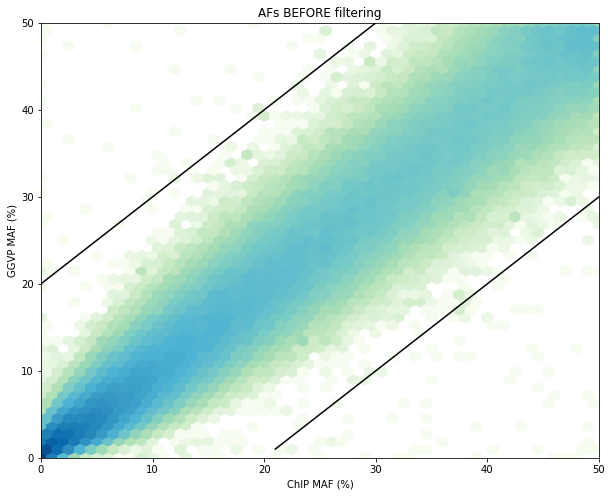

In [105]:
res = final[(final['prop_y'] != 1) & (final['prop_y'] != 0)]
delta = ((res['prop_x'] - res['prop_y'])**2/(res['prop_y']*(1-res['prop_y']))).sum()/(2*res.shape[0])

nstd = 4

y = np.arange(1,51)/100

# xp = nstd*np.sqrt(y*(1-y)*delta) + y+0.05
# xm = -nstd*np.sqrt(y*(1-y)*delta) + y-0.02

xp = y+0.2
xm = y-0.2

plt.figure(figsize=(10, 8))
plt.hexbin(res['prop_x']*100, res['prop_y']*100, gridsize = 50, bins = 'log', cmap = 'GnBu')
plt.xlabel('ChIP MAF (%)')
plt.ylabel('GGVP MAF (%)')
plt.title('AFs BEFORE filtering')
plt.plot(xp*100, y*100, color = 'black')
plt.plot(xm*100, y*100, color = 'black')
plt.xlim([0, 50])
plt.ylim([0, 50])

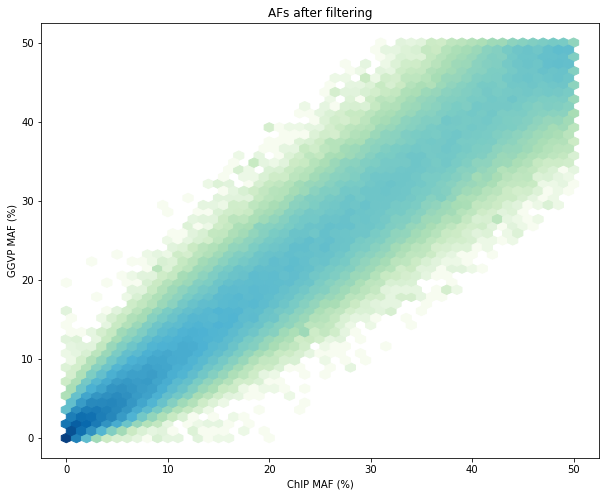

In [110]:
# filtered = res[((res['prop_x'] - res['prop_y']-0.05)/np.sqrt(res['prop_y']*(1-res['prop_y'])) <= nstd*np.sqrt(delta)) & 
#           ((-res['prop_x'] + res['prop_y']+0.02)/np.sqrt(res['prop_y']*(1-res['prop_y'])) <= nstd*np.sqrt(delta))]
# This removed 80,000 sites

filtered = final[abs(final['prop_x'] - final['prop_y']) <= 0.2]
drop_history['filter_maf'] = num - filtered.shape[0]
num = filtered.shape[0]

plt.figure(figsize=(10, 8))
plt.hexbin(filtered['prop_x']*100, filtered['prop_y']*100, gridsize = 50, bins = 'log', cmap = 'GnBu')
plt.xlabel('ChIP MAF (%)')
plt.ylabel('GGVP MAF (%)')
plt.title('AFs after filtering')
plt.show()

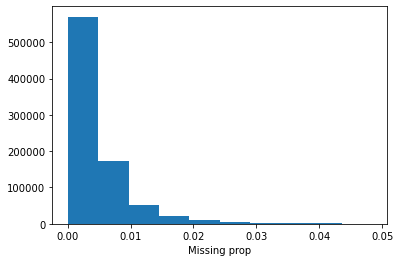

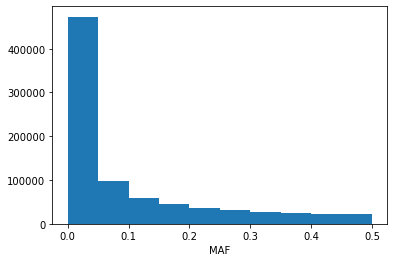

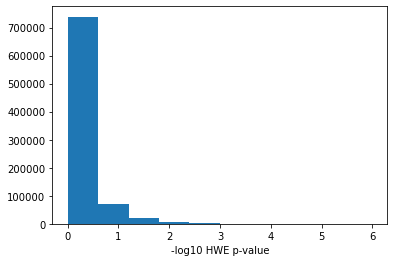

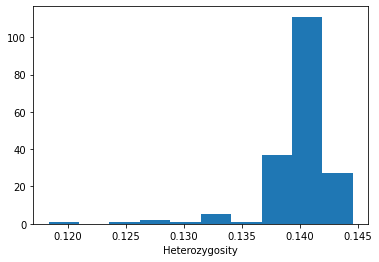

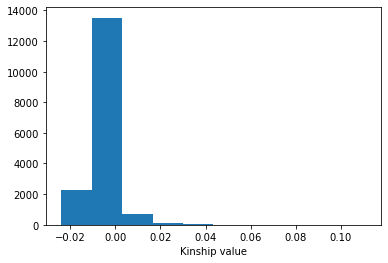

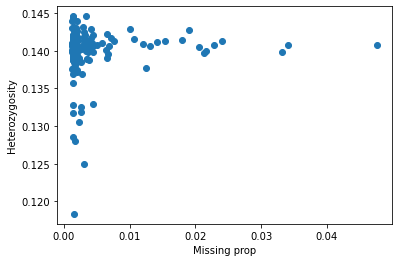

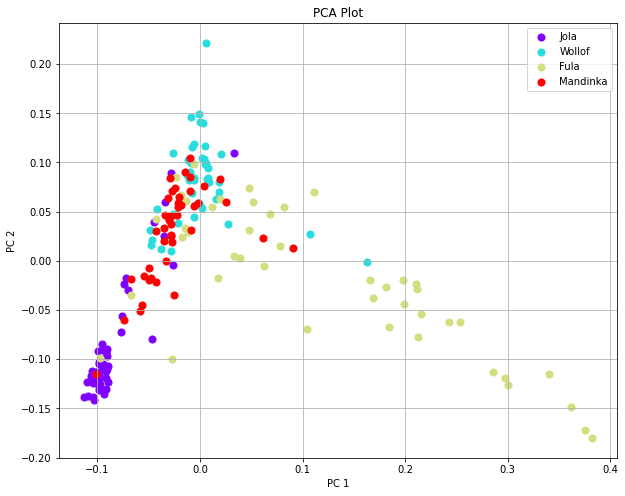

<Figure size 720x576 with 0 Axes>

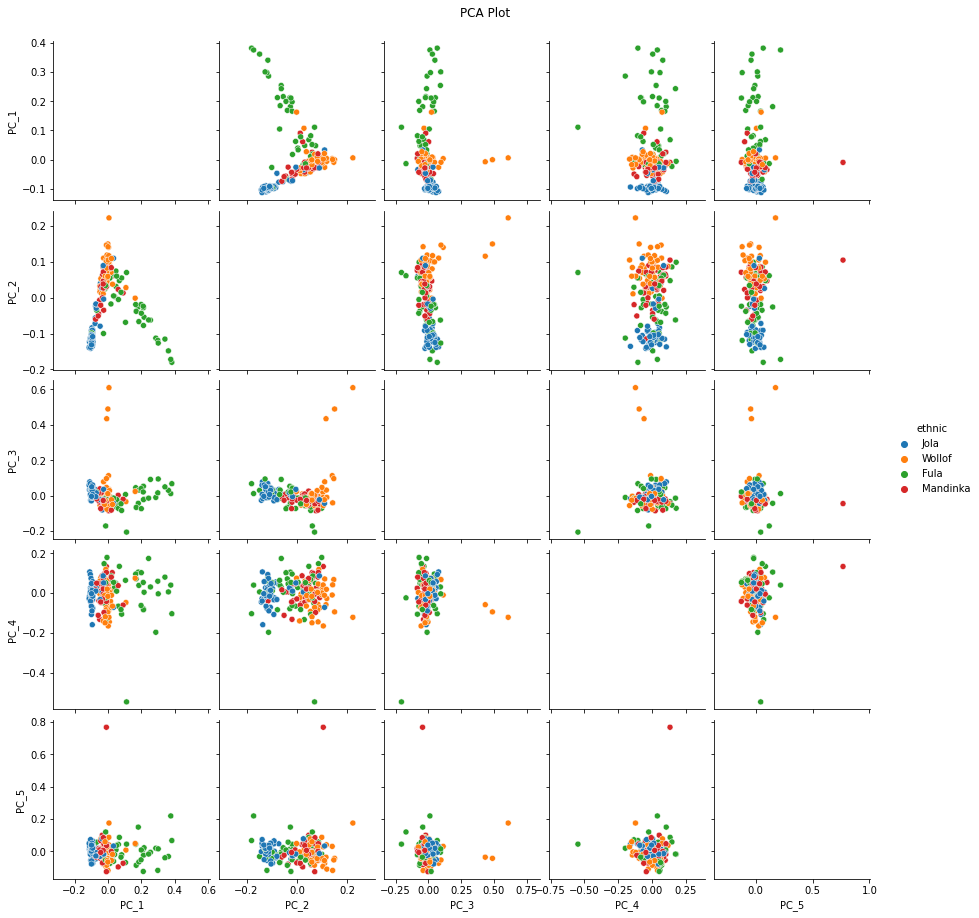

In [112]:
plt.hist(snp['missing_proportion'])
plt.xlabel('Missing prop')
plt.show()

plt.hist(snp['minor_allele_frequency'])
plt.xlabel('MAF')
plt.show()

plt.hist(-np.log10(snp['HW_exact_p_value']))
plt.xlabel('-log10 HWE p-value')
plt.show()

plt.hist(sample['heterozygous_proportion'])
plt.xlabel('Heterozygosity')
plt.show()

plt.hist(kinship[kinship['sample_1'] != kinship['sample_2']]['value'])
plt.xlabel('Kinship value')
plt.show()

plt.scatter(sample['missing_proportion'], sample['heterozygous_proportion'])
plt.xlabel('Missing prop')
plt.ylabel('Heterozygosity')
plt.show()

lcwgsus.plot_pc(PC)

lcwgsus.plot.plot_pc(PC, 5)

In [126]:
drop_history

{'original': 838125,
 'drop_non-autosome': 188,
 'drop_snp_missing_0.2': 854,
 'drop_snp_hwe_1e-6': 365,
 'drop_snp_missing_0.05': 1,
 'join_ref': 190657,
 'filter_maf': 68}

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

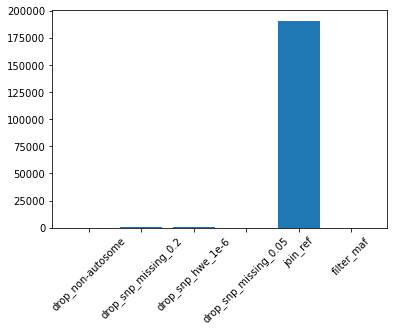

In [125]:
plt.bar(list(drop_history.keys())[1:],list(drop_history.values())[1:])
plt.xticks(rotation=45)

In [ ]:
db2 = sqlite3.connect( "results/chip/qc/chip.qc.gavin.sqlite" )
PC2 = pd.read_sql_query( "SELECT * FROM PCsView", db2 )
PC2 = PC2[PC2['analysis']=='PCs:thin_1bp:exclude-duplicates']
PC2 = PC2.merge(ethnic, on = 'sample_id', how = 'left')
plot = sns.pairplot(PC2[['PC_' + str(i) for i in range(1,6)] + ['ethnic']], hue="ethnic", diag_kind="kde", diag_kws={"linewidth": 0, "shade": False})
plot.fig.suptitle('Removing 2 samples', y = 1.02)
plt.show()

In [144]:
chip_filtered = filtered.drop(columns = ['ref', 'alt', 'prop_x', 'prop_y'])
chip_filtered.to_csv('results/chip/vcf/retain_sites.tsv', sep = '\t', header = False, index = False)
# samples_removed = pd.DataFrame({'samples': ['GAM370894', 'GAM916387', 'GAM654203']}) 
# samples_removed.to_csv('results/chip/vcf/drop_samples.tsv', sep = '\t', header = False, index = False)

In [145]:
df1 = pd.read_sql_query( "SELECT * FROM autosomesView", db )
df1 = df1[['chromosome', 'position', 'alleleA', 'alleleB', 'minor_allele_frequency']]
df1 = df1.rename(columns = {'chromosome': 'chr', 'position': 'pos', 'alleleA': 'ref', 'alleleB': 'alt', 'minor_allele_frequency': 'prop'})
df1 = df1[df1['chr'].isin([str(i) for i in range(1,23)])]
df1['chr'] = df1['chr'].astype(int)
df1['ref'] = df1['ref'].astype(str)
df1['alt'] = df1['alt'].astype(str)
df2 = chip_filtered
merged_df = pd.merge(df1, df2, on=['chr', 'pos'], how='left', indicator=True)
remaining_rows_df1 = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])
chip_dropped = remaining_rows_df1.drop(columns = ['ref', 'alt', 'prop'])
chip_dropped.to_csv('results/chip/vcf/dropped_sites.tsv', sep = '\t', header = False, index = False)

In [147]:
remaining_rows_df1

,chr,pos,ref,alt,prop
0,1,86028,T,C,0.000000
38,1,921057,G,-,0.036111
43,1,931771,G,A,0.000000
47,1,943317,G,A,0.000000
48,1,944011,GA,-,0.000000
...,...,...,...,...,...
837911,22,50707539,A,G,0.000000
837927,22,50737860,G,A,0.000000
837928,22,50738306,C,T,0.000000
837929,22,50739858,C,-,0.000000
